### Time Series Forecasting using LSTMs for Daily Coronavirus Cases


In [86]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [87]:
!gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV
To: /content/time_series_19-covid-Confirmed.csv
100% 19.2k/19.2k [00:00<00:00, 23.5MB/s]


In [88]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')

In [89]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,...,989,989,989,989,989,989,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,...,399,399,399,400,400,410,410,411,413,414
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,...,573,575,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,...,293,293,293,294,294,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,91,91,91,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,"Placer County, CA",US,39.0916,-120.8039,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
138,"San Mateo, CA",US,37.5630,-122.3255,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
139,"Sarasota, FL",US,27.3364,-82.5307,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
140,"Sonoma County, CA",US,38.5780,-122.9888,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [90]:
df = df.iloc[:, 4:]

In [91]:
df

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,1,9,15,39,60,70,106,152,200,237,...,989,989,989,989,989,989,990,990,990,990
1,14,22,36,41,68,80,91,111,114,139,...,399,399,399,400,400,410,410,411,413,414
2,6,9,27,57,75,110,132,147,182,211,...,573,575,576,576,576,576,576,576,576,576
3,1,5,10,18,35,59,80,84,101,120,...,293,293,293,294,294,296,296,296,296,296
4,0,2,2,4,7,14,19,24,26,29,...,91,91,91,91,91,91,91,91,91,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [92]:
df.isnull().sum()

,0
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,0
1/27/20,0
1/28/20,0
1/29/20,0
1/30/20,0
1/31/20,0


In [93]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

<ipython-input-93-c405529681bc>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  daily_cases.index = pd.to_datetime(daily_cases.index)


,0
2020-01-22,555
2020-01-23,653
2020-01-24,941
2020-01-25,1434
2020-01-26,2118


Text(0.5, 1.0, 'Cummulative Cases')

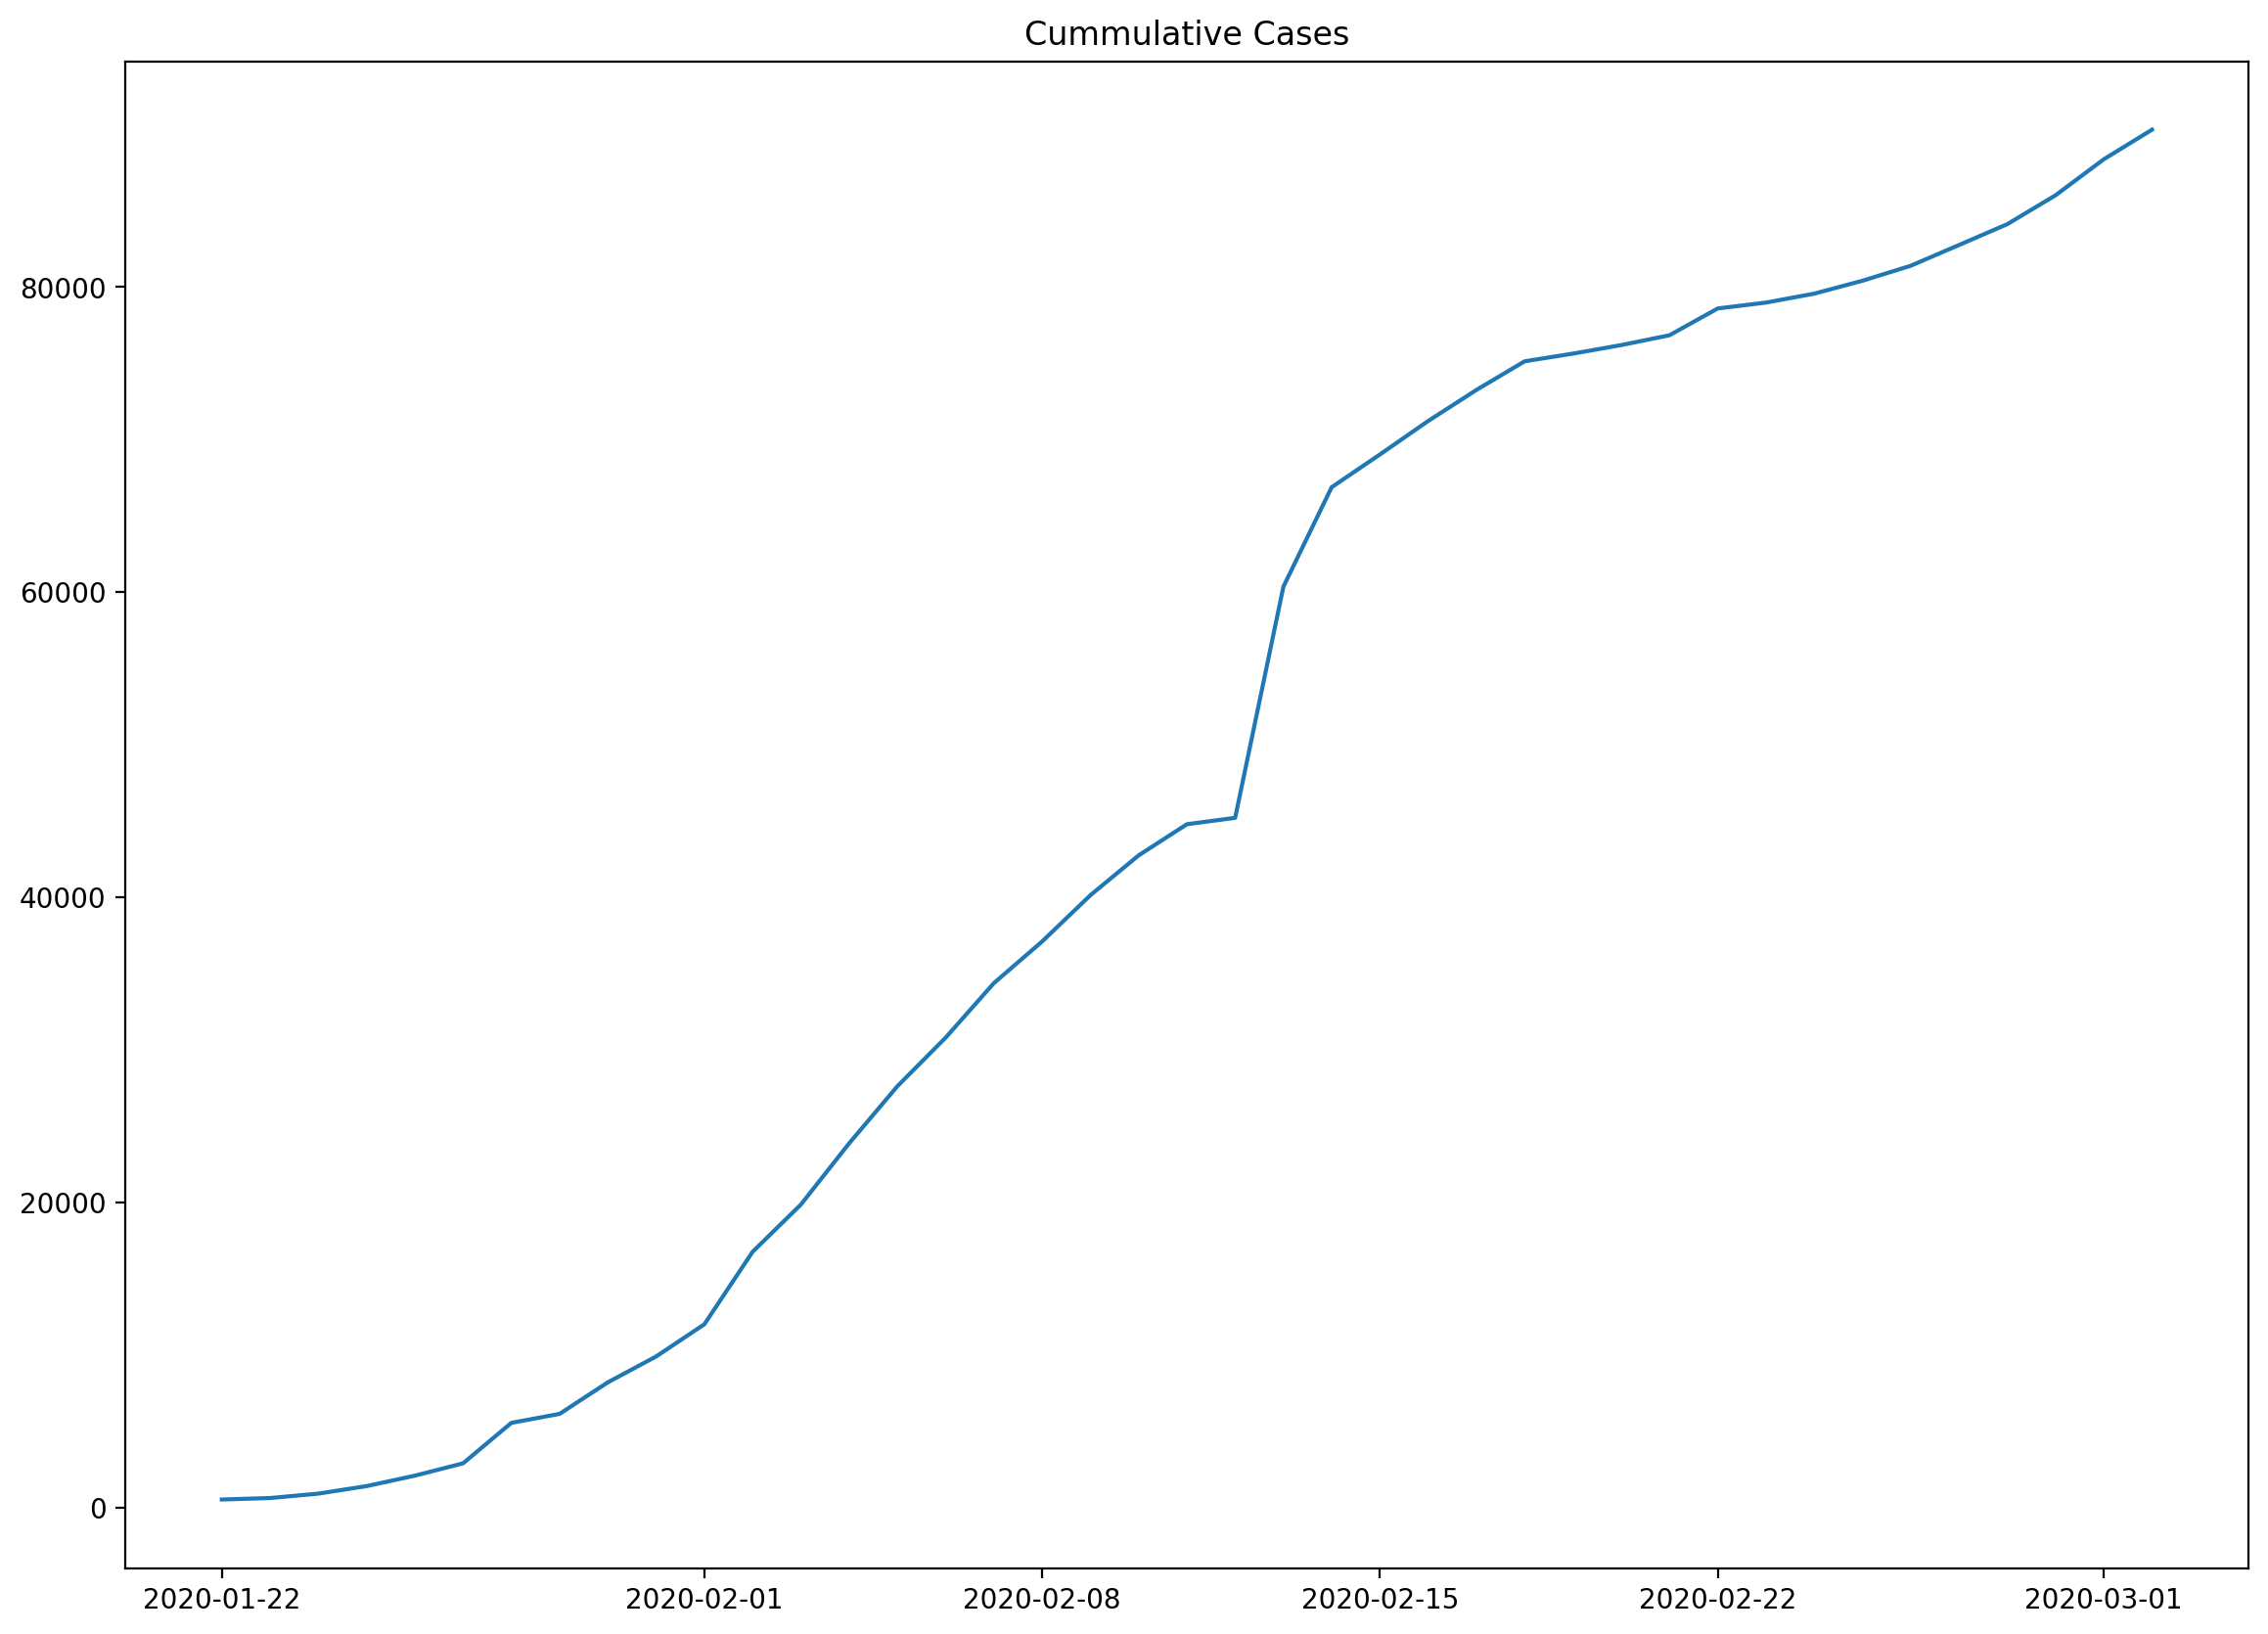

In [94]:
plt.plot(daily_cases)
plt.title("Cummulative Cases")

In [95]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)

<ipython-input-95-ea9d2fe06fe9>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)


In [96]:
daily_cases.head()

,0
2020-01-22,555
2020-01-23,98
2020-01-24,288
2020-01-25,493
2020-01-26,684


Text(0.5, 1.0, 'Daily Cases')

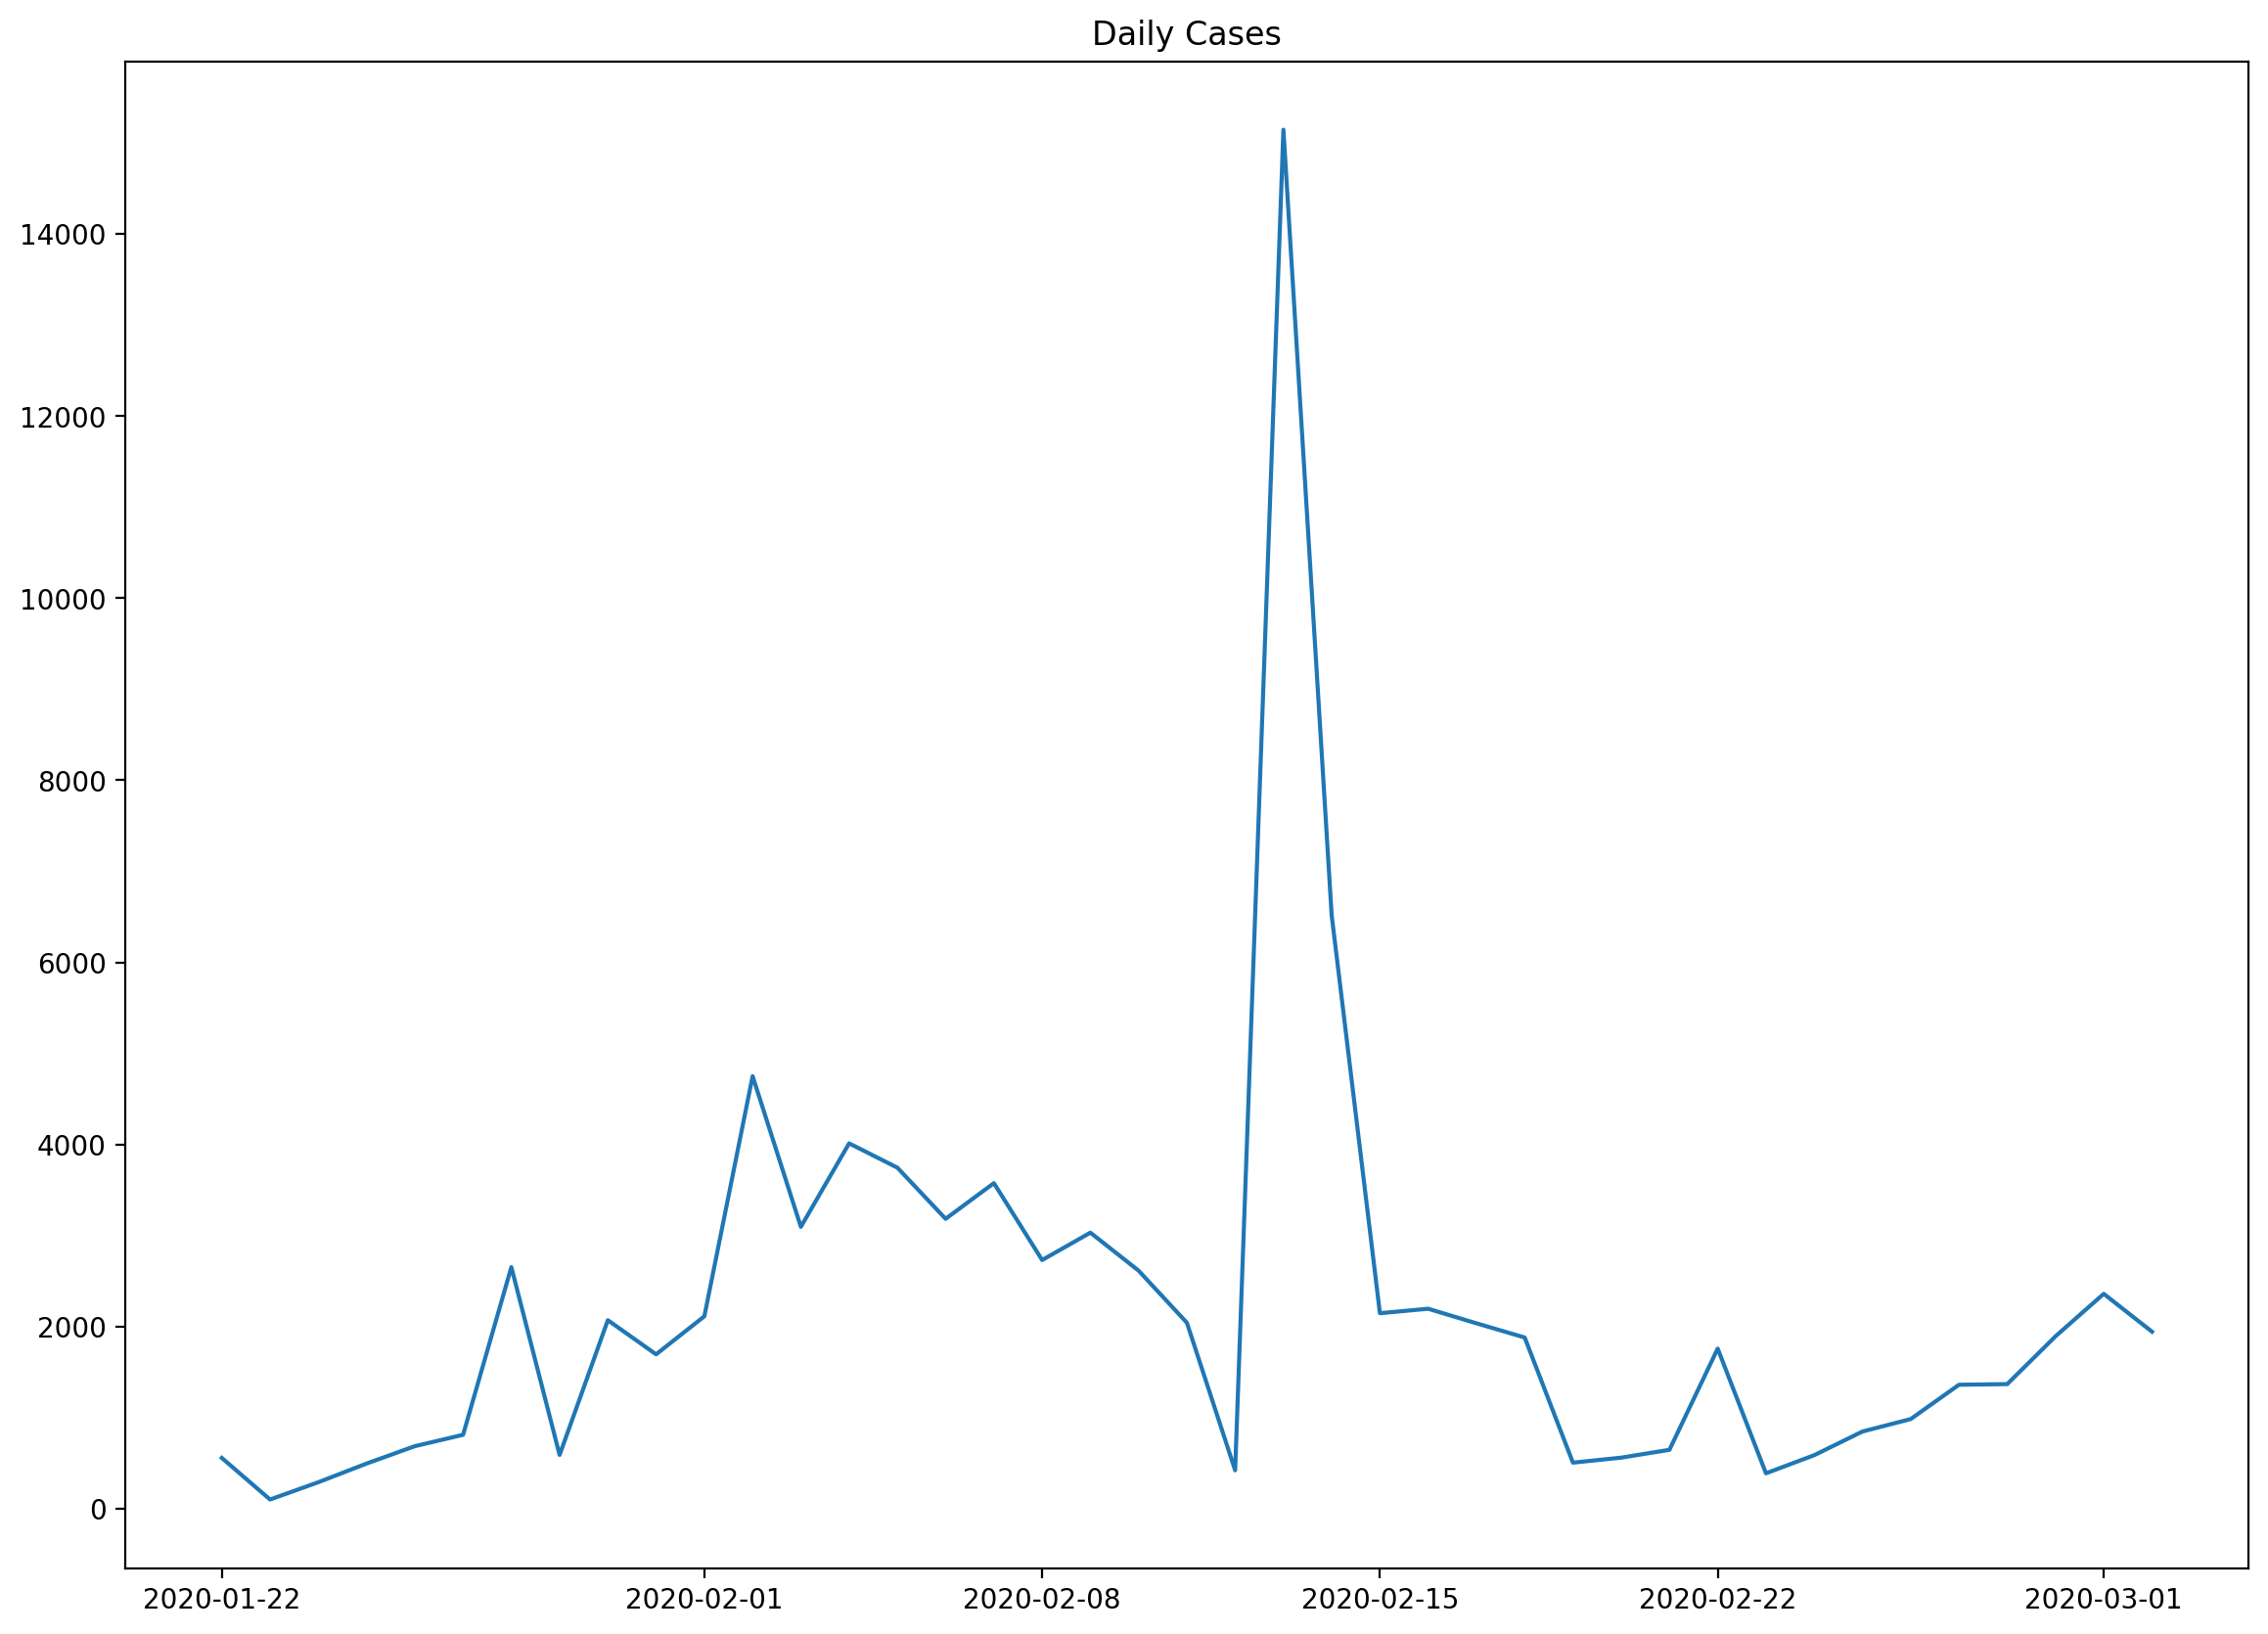

In [97]:
plt.plot(daily_cases)
plt.title('Daily Cases')

In [98]:
daily_cases.shape

(41,)

In [99]:
test_data_size = 14
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data

,0
2020-01-22,555
2020-01-23,98
2020-01-24,288
2020-01-25,493
2020-01-26,684
2020-01-27,809
2020-01-28,2651
2020-01-29,588
2020-01-30,2068
2020-01-31,1693


In [100]:
from sklearn.preprocessing import MinMaxScaler

In [101]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [102]:
def create_sequences(data, seq_length):
  xs = []
  ys = []

  for i in range(len(data) - seq_length-1):
    x = data[i:(i+seq_length)]
    y = data[i+seq_length]
    xs.append(x)
    ys.append(y)

  return np.array(xs), np.array(ys)

seq_length = 5

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [103]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [104]:
X_train.shape

torch.Size([21, 5, 1])

In [105]:
X_train[:2]

tensor([[[0.0304],
         [0.0000],
         [0.0126],
         [0.0262],
         [0.0389]],

        [[0.0000],
         [0.0126],
         [0.0262],
         [0.0389],
         [0.0472]]])

In [106]:
y_train.shape

torch.Size([21, 1])

In [107]:
y_train[:2]

tensor([[0.0472],
        [0.1696]])

### Building a model

In [108]:
class CoronaVirusPredictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers = 2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        dropout = 0.2
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
        sequences.view(len(sequences), self.seq_len, -1),
        self.hidden
    )
    last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]

    y_pred = self.linear(last_time_step)

    return y_pred

### Training

In [109]:
def train_model(
    model,
    train_data,
    train_labels,
    test_data = None,
    test_labels = None
):
  loss_fn = torch.nn.MSELoss(reduction="sum")

  optimiser = torch.optim.Adam(model.parameters(), lr = 1e-3)

  num_epochs = 80

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 ==0:
        print(f"Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}")
    elif t % 10 == 0:
      print(f"Epoch {t} train loss: {loss.item()}")

    train_hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  return model.eval(), train_hist, test_hist

In [110]:
model = CoronaVirusPredictor(
    n_features = 1,
    n_hidden = 512,
    seq_len = seq_length,
    n_layers = 2
)

model, train_hist, test_hist = train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test
)

Epoch 0 train loss: 1.6212725639343262 test loss: 0.04012097418308258
Epoch 10 train loss: 0.8441063165664673 test loss: 0.11471901834011078
Epoch 20 train loss: 0.8227769732475281 test loss: 0.15359684824943542
Epoch 30 train loss: 0.8170365691184998 test loss: 0.20244215428829193
Epoch 40 train loss: 0.8141834735870361 test loss: 0.1788700819015503
Epoch 50 train loss: 0.8107630610466003 test loss: 0.21605724096298218
Epoch 60 train loss: 0.791412889957428 test loss: 0.30189573764801025
Epoch 70 train loss: 0.743676483631134 test loss: 0.5106928944587708


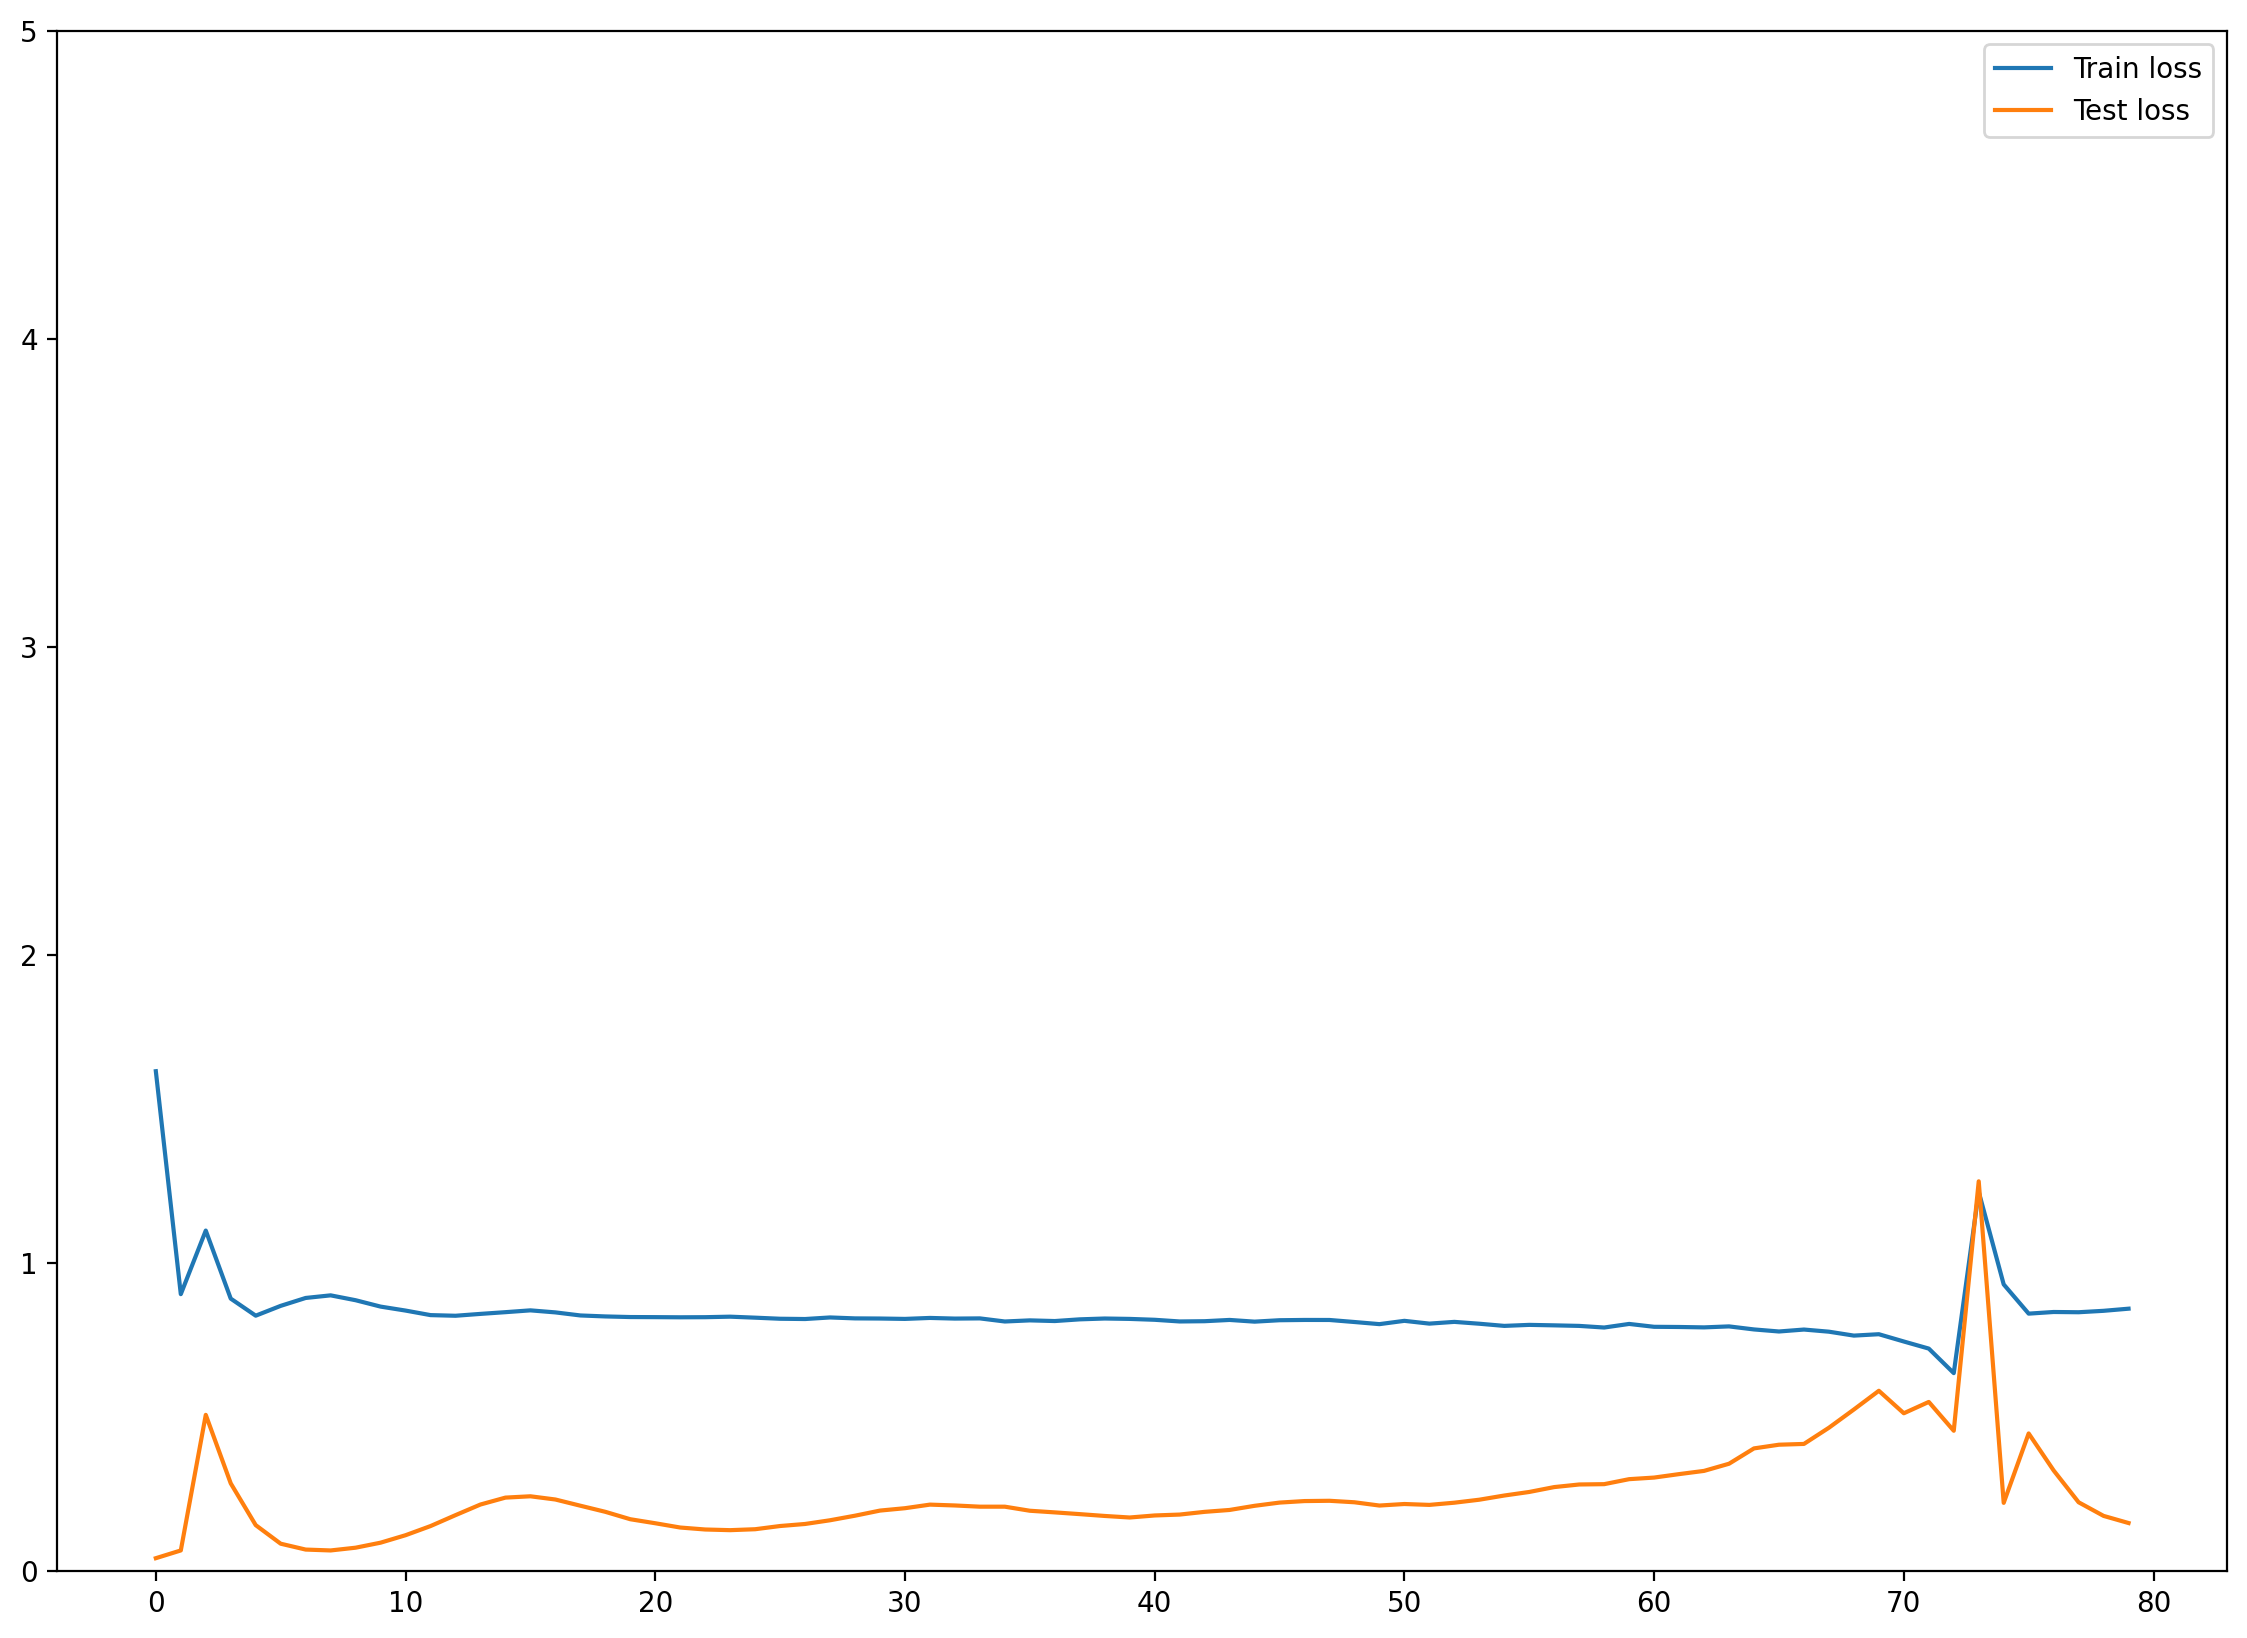

In [111]:
plt.plot(train_hist, label="Train loss")
plt.plot(test_hist, label = "Test loss")
plt.ylim((0, 5))
plt.legend()

### That's a shitty model, the loss starts increasing

### Predicting daily cases

In [112]:
with torch.no_grad():
  test_seq = X_test[:1]

  preds = []
  for _ in range(len(test_data)):
    y_test_pred = model(test_seq)
    pred = y_test_pred[-1].item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [114]:
true_cases = scaler.inverse_transform(np.expand_dims(y_test.flatten().numpy(), axis=0)).flatten()
predicted_cases = scaler.inverse_transform(np.expand_dims(preds, axis = 0)).flatten()

ValueError: x and y must have same first dimension, but have shapes (8,) and (14,)

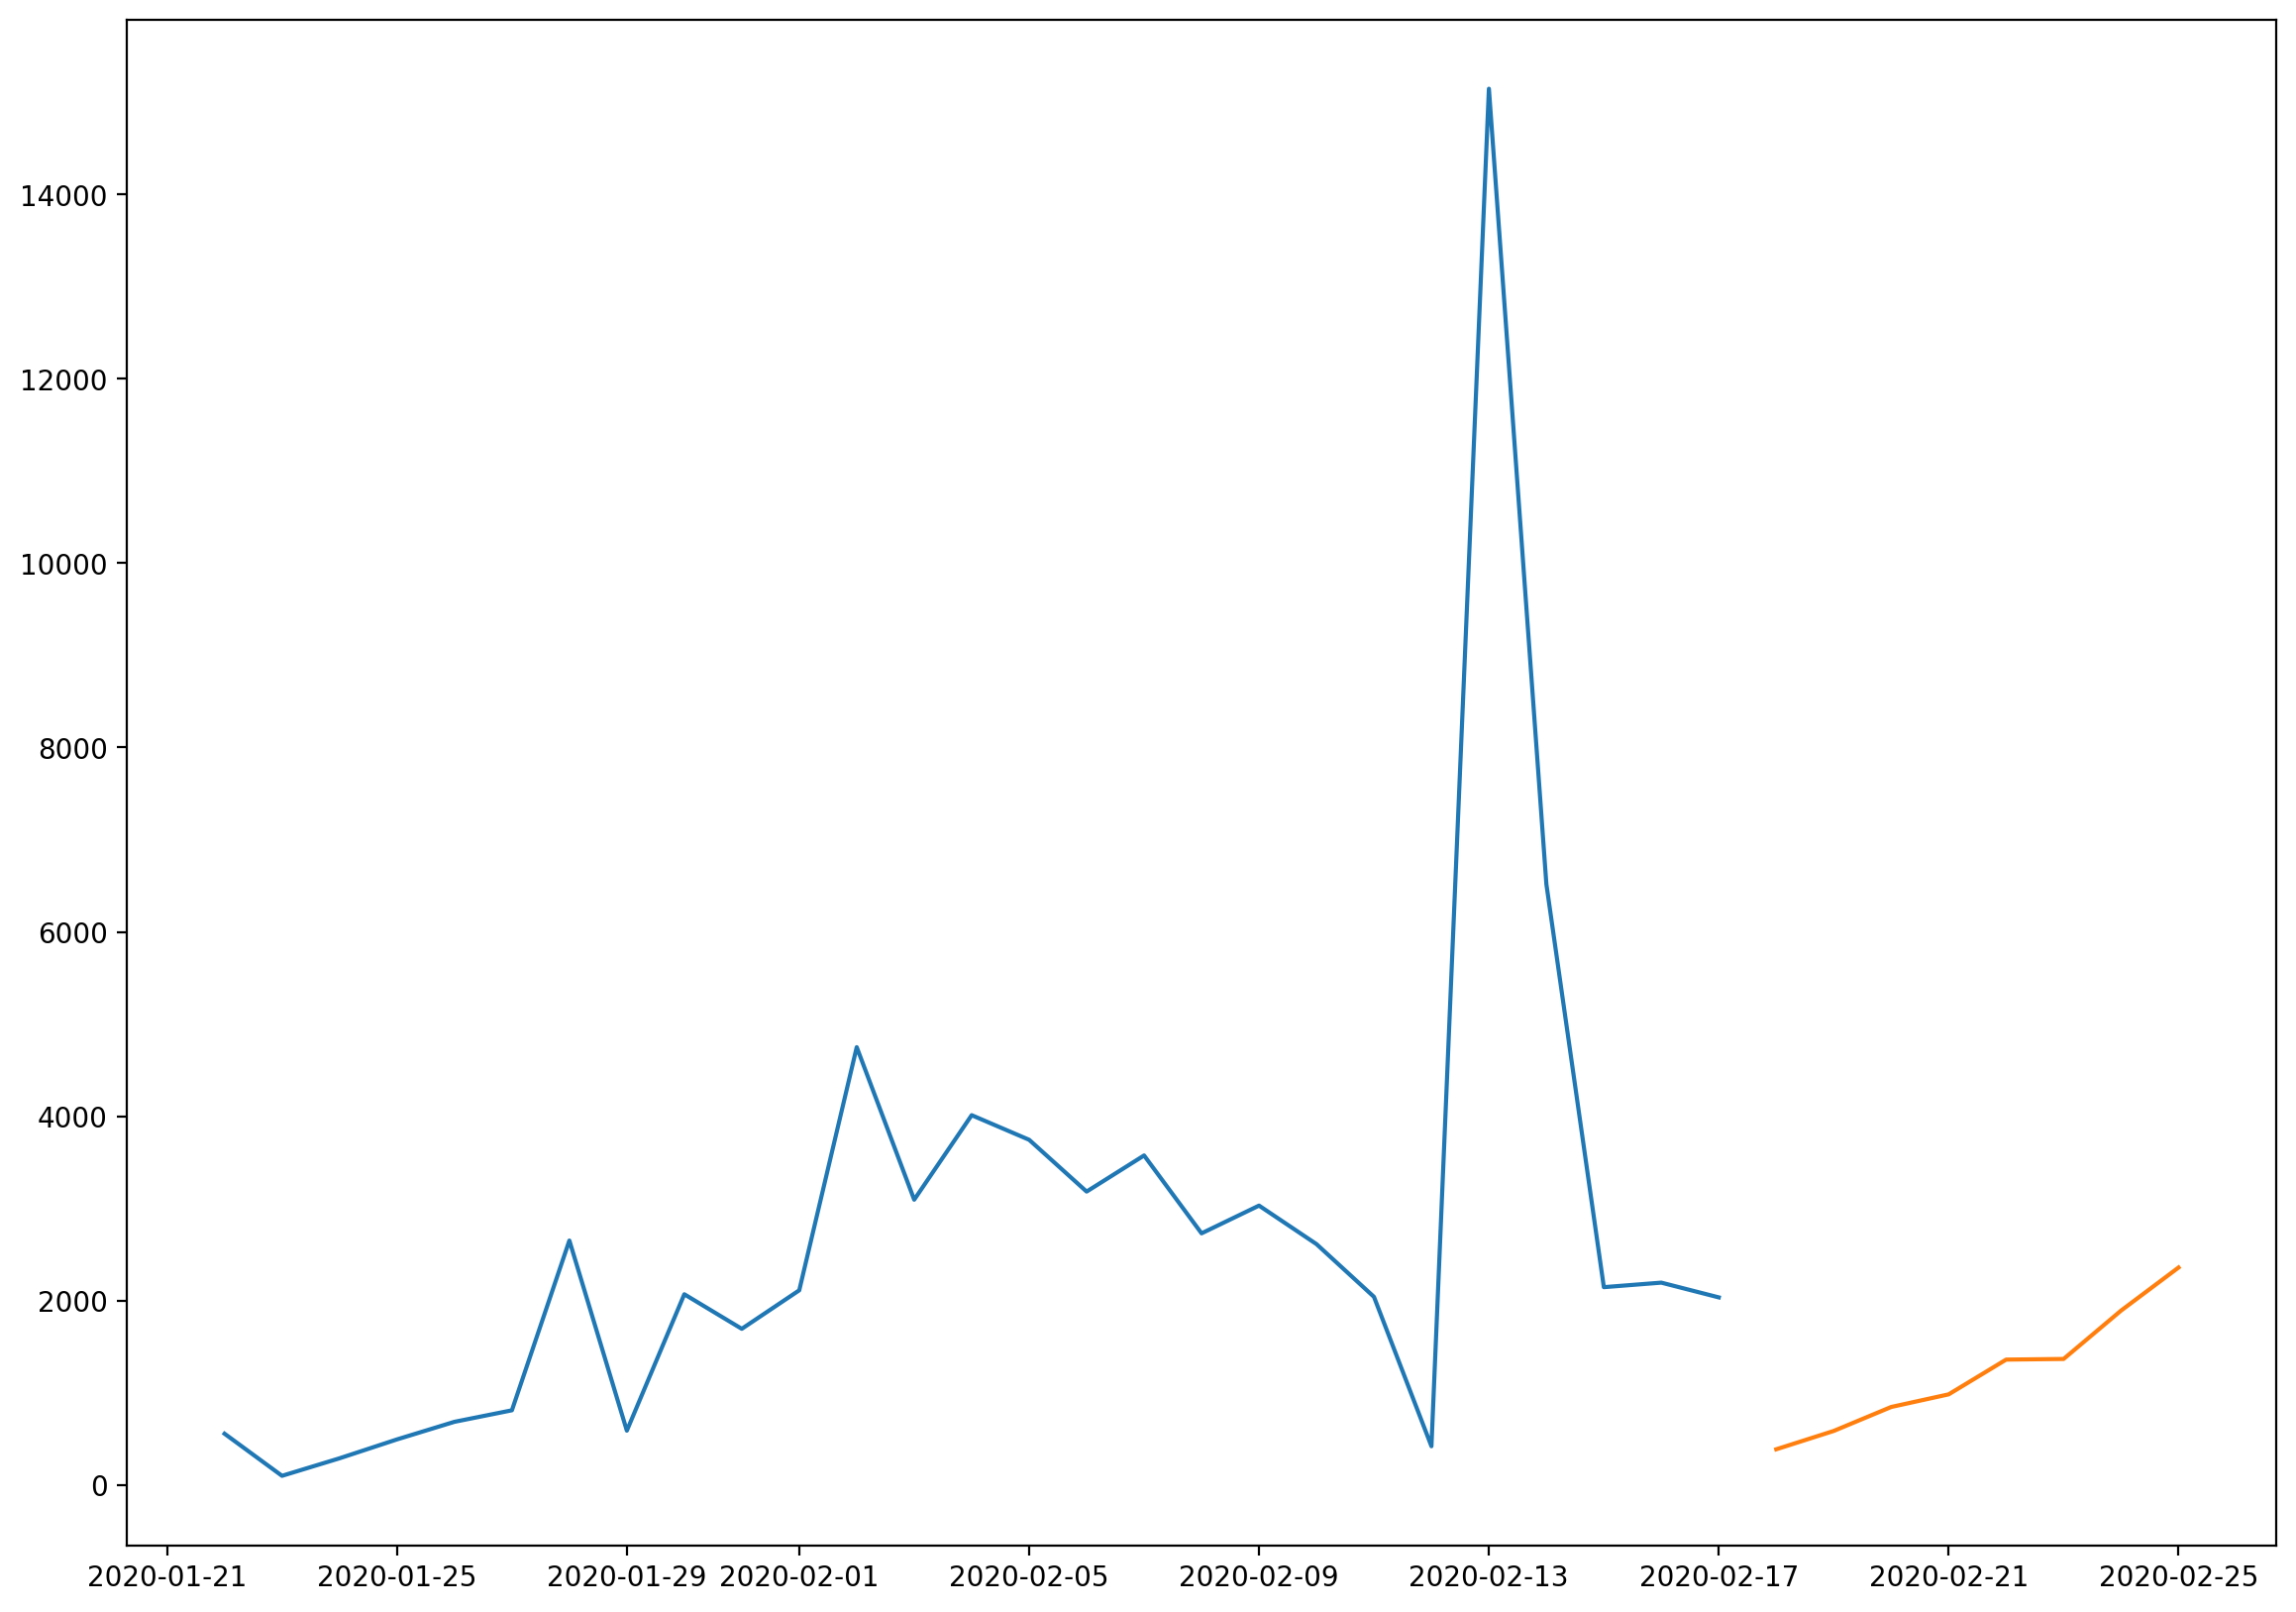

In [116]:
plt.plot(
  daily_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)

plt.legend()